# Convex Regression

Convex regression experiments on synthetic problems.<br/>
See the [Notebook parameters](#__notebook_params__) cell for the settings.

In [1]:
import os
import sys
import time
import logging
import traceback

project_path = os.path.abspath('.' if 'requirements.txt' in os.listdir() else '..')
if project_path not in sys.path:
    sys.path.append(project_path)
print('project_path: {}'.format(project_path))

project_path: /home/bege/Project/Cvxreg/cvxreg


In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from joblib import Parallel, delayed, Memory
from collections import OrderedDict
from IPython.display import display

from common.util import set_random_seed, eprint

In [3]:
logging.basicConfig(
    handlers=(
        # logging.FileHandler('.../file.log'),
        logging.StreamHandler(sys.stdout),
    ),
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    format='%(asctime)s|%(levelname)s|%(message)s',
)

def info(*args):
    logging.info('PID:{}|'.format(os.getpid()) + args[0] + '\n', *args[1:])

## Notebook parameters <a class="anchor" id="__notebook_params__"></a>
The next cell is tagged by <code>parameters</code> for [papermill](https://papermill.readthedocs.io).

In [4]:
experiment_id = '_MISSING_ID'  # Name your experiment here!
loss = 'l2'  # 'l1', 'l2'
target_func = 'l1_quad'
#    'linear': linear function
#    'symm_l1': symmetric L1 norm (even, convex)
#    'trunc_l1': truncated L1 norm (convex)
#    'symm_quad': symmetric quadratic function (even, convex)
#    'trunc_quad': truncated quadratic function (convex)
covariate_distr = 'full_dim_normal'
#    'full_dim_normal[:std=1.0]': full dimensional normal distribution
#    'full_dim_uniform[:max=2.0][:min=-2.0]': full dimensional uniform distribution
#    'embed_uniform[:low_d=3][:meas_noise_std=0.1][:max=3.0][:min=-3.0]':
#        uniform random variable linearly embedded into a larger space with Gaussian measurement noise
#    'poly_uniform[:meas_noise_std=0.1][:max=1.0][:min=-1.0]':
#        uniform random variable with polynomial expansion and Gaussian measurement noise
observation_noise = 'normal'
#    'normal[:std=0.3]': Gaussian distribution
#    'rademacher': Rademacher distribution
global_random_seed = None  # nonnegative integer, setting under 10000 turns on caching
domain_dims = '3,5'  # domain dimensions
nsamples = '100,250'  # number of samples
nruns = 3  # number of experiment runs
ntestsamples = int(1e6)  # number of test samples to generate
parallel_nworkers = 1  # maximum number of parallel workers (make sure you have enough RAM too)
parallel_backend = 'multiprocessing'

In [5]:
def get_int_tuple(param):
    if isinstance(param, str):
        return tuple([int(v) for v in param.split(',')])
    elif isinstance(param, int):
        return (param,)
    return param

if global_random_seed is not None:
    global_random_seed = int(global_random_seed)
domain_dims = get_int_tuple(domain_dims)
nsamples = get_int_tuple(nsamples)
nruns = int(nruns)
ntestsamples = int(ntestsamples)
parallel_nworkers = int(parallel_nworkers)

In [6]:
seed_limit = 1e6
if global_random_seed is None:
    global_random_seed = 10000 + int(np.round((time.time() % 1) * seed_limit))
set_random_seed(global_random_seed)
setup_random_seed = np.random.randint(seed_limit)
data_random_seed = np.random.randint(seed_limit)
training_random_seed = np.random.randint(seed_limit)
testing_random_seed = np.random.randint(seed_limit)
info('random seeds, global:{}, setup:{}, data:{}, training:{}, testing:{}'.format(
    global_random_seed, setup_random_seed, data_random_seed,
    training_random_seed, testing_random_seed,
))

2025-01-27 13:39:23|INFO|PID:16987|random seeds, global:994318, setup:849142, data:245540, training:197863, testing:90856



## Estimators

In [7]:
set_random_seed(setup_random_seed)
estimators = OrderedDict()

def get_estimator(estimator_name):
    return estimators[estimator_name]

In [8]:
# Ordinary Least-Squares estimator
from common.ols import OLSEstimator
estimators['OLS'] = OLSEstimator()

In [9]:
# # LSPA
# from algorithm.lspa.lspa import LSPAEstimator
# estimators['LSPA'] = LSPAEstimator(train_args={'ncenters': 'n**(d/(d+4))', 'nrestarts': 'd', 'nfinalsteps': 'n'})

In [10]:
# # CNLS
# from algorithm.cnls.cnls import CNLSEstimator
# estimators['CNLS_star'] = CNLSEstimator(train_args={'use_L': True})
# estimators['CNLS_ln'] = CNLSEstimator(train_args={'use_L': True, 'override_L': 'np.log(n)'})

In [11]:
# Convex Adaptive Partitioning (CAP)
from algorithm.cap.cap import CAPEstimator
estimators['CAP'] = CAPEstimator()
# estimators['FastCAP'] = CAPEstimator(train_args={'nranddirs': 5})

In [12]:
# # PCNLS with random Voronoi partition
# from algorithm.pcnls.pcnls_voronoi import PCNLSVoronoiEstimator
# estimators['PCNLS-Voronoi'] = PCNLSVoronoiEstimator()

In [13]:
# Adaptive Max-Affine Partitioning (AMAP)
from algorithm.amap.amap import AMAPEstimator
estimators['AMAP'] = AMAPEstimator()

In [14]:
# # APCNLS
from algorithm.apcnls.apcnls import APCNLSEstimator
estimators['APCNLS_star'] = APCNLSEstimator(train_args={'use_L': True})
estimators['APCNLS_ln'] = APCNLSEstimator(train_args={'use_L': True, 'override_L': 'np.log(n)'})
# estimators['APCNLS_reg'] = APCNLSEstimator(train_args={'use_L': False, 'L_regularizer': 'AUTO'})

### Non-convex regressors

In [15]:
# !pip install xgboost
from algorithm.external.xgboost import XgbEstimator
estimators['XGB'] = XgbEstimator(objective='reg:absoluteerror') if loss == 'l1' else XgbEstimator()

In [16]:
# !pip install scikit-learn
from algorithm.external.random_forest import RandomForestEstimator
estimators['RF'] = RandomForestEstimator()

In [17]:
# # !pip install scikit-learn
# from algorithm.external.nearest_neighbors import NearestNeighborsEstimator
# estimators['KNN+'] = NearestNeighborsEstimator(n_neighbors='AFPC', cv=5, afpc_ntrials=10)
# estimators['KNN*'] = NearestNeighborsEstimator(n_neighbors='n**(d/(2+d))', cv=5)

In [18]:
# # !pip install scikit-learn scikit-fda
# from algorithm.external.kernel_regression import KernelRegEstimator
# estimators['kreg_nor'] = KernelRegEstimator('normal')
# estimators['kreg_epa'] = KernelRegEstimator('epanechnikov')
# estimators['kreg_tri'] = KernelRegEstimator('tri_weight')

## Caching

In [19]:
from common.cache import ResultCache
result_cache = ResultCache(
    is_enabled=(global_random_seed < 10000), # caching is pointless without manual random seed setting
    project_path=project_path,
    experiment_id=experiment_id,
)
print(f'is_caching_enabled: {result_cache.is_enabled()}')
output_dir = None
if result_cache.is_enabled():
    output_dir = os.path.join(result_cache.cache_dir,
                              f'stats-seed{global_random_seed}-r{nruns}'
                              + '-n' + ','.join([str(n) for n in nsamples]))
    os.makedirs(output_dir, exist_ok=True)
    print(f'output_dir: {output_dir}')

is_caching_enabled: False


## Problem setting

In [20]:
L = np.inf  # Lipschitz limit (can be set as a function to measure L on the union of the training and test sets)
L_scaler = 1.0  # multiplying L (makes sense when L is measured on the data)
X_mean = 0.0

In [21]:
from common.experiment import loss_l1, loss_l2, loss_linf

report_loss_name = loss
stat_losses = {'l1': loss_l1, 'l2': loss_l2, 'linf': loss_linf}

#### Target function

In [22]:
if target_func == 'linear':
    def fstar(X):
        return np.sum(X, axis=1)
    L = 1.0
elif target_func == 'symm_l1':
    def fstar(X):
        return np.sum(np.abs(X), axis=1)
    def L_func(X):
        return max(np.linalg.norm(np.sign(X), ord=2, axis=1))
    L = L_func
elif target_func == 'trunc_l1':
    def fstar(X):
        return np.sum(np.abs(np.maximum(X, 0.0)), axis=1)
    def L_func(X):
        return max(np.linalg.norm(np.sign(np.maximum(X, 0.0)), ord=2, axis=1))
    L = L_func
elif target_func == 'symm_quad':
    def fstar(X):
        return 0.5 * np.sum(np.square(X), axis=1)
    def L_func(X):
        return max(np.linalg.norm(X, ord=2, axis=1))
    L = L_func
elif target_func == 'trunc_quad':
    def fstar(X):
        return 0.5 * np.sum(np.square(np.maximum(X, 0.0)), axis=1)
    def L_func(X):
        return max(np.linalg.norm(np.maximum(X, 0.0), ord=2, axis=1))
    L = L_func
elif target_func == 'l1_quad':
    def fstar(X):
        return (
            np.sum(np.abs(np.maximum(1.0-X, 0.0)), axis=1)
            + np.sum(np.square(np.maximum(X-1.0, 0.0)), axis=1)
        )
    def L_func(X):
        return max(max(np.linalg.norm(np.sign(np.maximum(1.0-X, 0.0)), ord=2, axis=1)),
                   2.0*max(np.linalg.norm(np.maximum(X-1.0, 0.0), ord=2, axis=1)))
    L = L_func
else:
    raise Exception(f'Not supported target_func: {target_func}!')

#### Covariate distribution

In [23]:
covariate_distr_name = covariate_distr.split(':', 2)[0]
if covariate_distr_name == 'full_dim_normal':
    covariate_std = 1.0 if ':' not in covariate_distr else float(covariate_distr.split(':', 2)[1])
    assert covariate_std >= 0.0 

    def sample_X(n, d):
        return X_mean + np.random.randn(n, d) * covariate_std
elif covariate_distr_name == 'full_dim_uniform':
    covariate_max = 2.0 if ':' not in covariate_distr else float(covariate_distr.split(':', 2)[1])
    covariate_min = -covariate_max if covariate_distr.count(':') < 2 else float(covariate_distr.split(':', 3)[2])
    assert covariate_min < covariate_max

    def sample_X(n, d):
        return X_mean + np.random.rand(n, d) * (covariate_max - covariate_min) + covariate_min
elif covariate_distr_name == 'embed_uniform':
    low_d = 3 if ':' not in covariate_distr else int(covariate_distr.split(':', 2)[1])
    measurement_noise_std = 0.1 if covariate_distr.count(':') < 2 else float(covariate_distr.split(':', 3)[2])
    covariate_max = 3.0 if covariate_distr.count(':') < 3 else float(covariate_distr.split(':', 4)[3])
    covariate_min = -covariate_max if covariate_distr.count(':') < 4 else float(covariate_distr.split(':', 5)[4])
    assert low_d >= 1
    assert measurement_noise_std >= 0.0
    assert covariate_min < covariate_max

    def sample_X(n, d):
        X = np.random.randn(n, d) * measurement_noise_std
        X[:, :low_d] = np.random.rand(n, low_d) * (covariate_max - covariate_min) + covariate_min
        return X + X_mean
elif covariate_distr_name == 'poly_uniform':
    measurement_noise_std = 0.1 if ':' not in covariate_distr else float(covariate_distr.split(':', 2)[1])
    covariate_max = 1.0 if covariate_distr.count(':') < 2 else float(covariate_distr.split(':', 3)[2])
    covariate_min = -covariate_max if covariate_distr.count(':') < 3 else float(covariate_distr.split(':', 4)[3])
    assert measurement_noise_std >= 0.0
    assert covariate_min < covariate_max

    def sample_X(n, d):
        X = np.random.randn(n, d) * measurement_noise_std
        Z = np.random.rand(n) * (covariate_max - covariate_min) + covariate_min
        for power in range(d):
            X[:, power] += Z**power
        return X + X_mean
else:
    raise Exception(f'Not supported covariate_distr: {covariate_distr}!')

#### Observation noise distribution

In [24]:
observation_noise_name = observation_noise.split(':', 2)[0]
if observation_noise_name == 'normal':
    observation_noise_std = 0.3 if ':' not in observation_noise else float(observation_noise.split(':', 2)[1])

    def sample_noise(n):
        return np.random.randn(n) * observation_noise_std
elif observation_noise_name == 'rademacher':
    def sample_noise(n):
        return 2.0 * (np.random.randint(0, 2, n) - 0.5)
else:
    raise Exception(f'Not supported observation_noise: {observation_noise}!')

## Data

In [25]:
from common.experiment import get_random_seed_offset

def get_data(d, n, run, data_random_seed):
    seed = data_random_seed + get_random_seed_offset(d, n, run)
    print(f'seed: {seed}, d:{d}, n:{n}, run:{run}, data_random_seed:{data_random_seed}')
    set_random_seed(seed)

    X_train = sample_X(n, d)
    y_train_noiseless = fstar(X_train)
    y_train = y_train_noiseless + sample_noise(n)

    X_test = sample_X(ntestsamples, d)
    y_test = fstar(X_test)

    return X_train, y_train, X_test, y_test, y_train_noiseless

### AFPC statistics

seed: 245840, d:3, n:100, run:0, data_random_seed:245540
seed: 245841, d:3, n:100, run:1, data_random_seed:245540
seed: 245842, d:3, n:100, run:2, data_random_seed:245540
seed: 246290, d:3, n:250, run:0, data_random_seed:245540
seed: 246291, d:3, n:250, run:1, data_random_seed:245540
seed: 246292, d:3, n:250, run:2, data_random_seed:245540
seed: 246040, d:5, n:100, run:0, data_random_seed:245540
seed: 246041, d:5, n:100, run:1, data_random_seed:245540
seed: 246042, d:5, n:100, run:2, data_random_seed:245540
seed: 246790, d:5, n:250, run:0, data_random_seed:245540
seed: 246791, d:5, n:250, run:1, data_random_seed:245540
seed: 246792, d:5, n:250, run:2, data_random_seed:245540

Data statistics:


rad(X_train)  rad(X_test)     rad(y)  loss(ybar)   K  train_eps  \
d n   nrun                                                                    
3 100 0         3.842346     5.606341  17.398508    2.151141  16   1.505200   
      1         3.233386     5.874488  15.556267    2.145985  17   1.265800   
      2         4.013291     5.693946  14.598001    2.154201  16   1.432070   
  250 0         3.449132     5.519865  14.564672    2.150635  29   1.254744   
      1         4.396850     5.521850  14.949422    2.146824  24   1.328940   
      2         3.766432     5.808696  16.085020    2.149172  29   1.275909   
5 100 0         4.576874     6.421457  17.218603    3.586138  21   2.041934   
      1         4.255771     6.041114  17.020945    3.580912  24   2.083189   
      2         3.487323     6.129415  17.733295    3.590468  28   1.931673   
  250 0         4.829215     5.852183  15.587191    3.589987  43   1.991080   
      1         4.497111     5.905214  16.003526    3.586163  45   1.861648   
      2         4.761266     6.008053  17.512894    3.579063  43   1.947601   

            test_eps  
d n   nrun            
3 100 0     5.365149  
      1     5.575057  
      2     5.959548  
  250 0     5.199620  
      1     5.675962  
      2     4.990917  
5 100 0     5.613629  
      1     5.756885  
      2     5.578504  
  250 0     5.976068  
      1     6.400484  
      2     5.939135

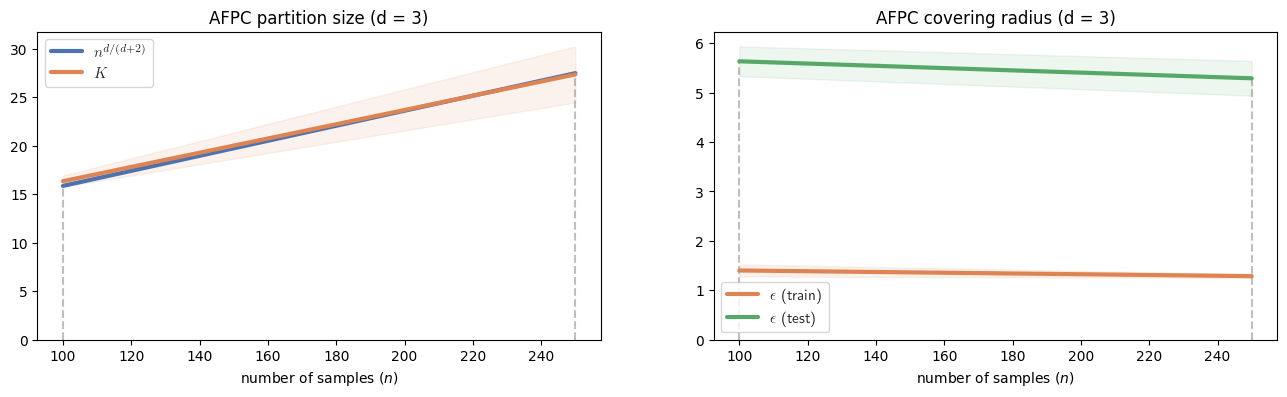

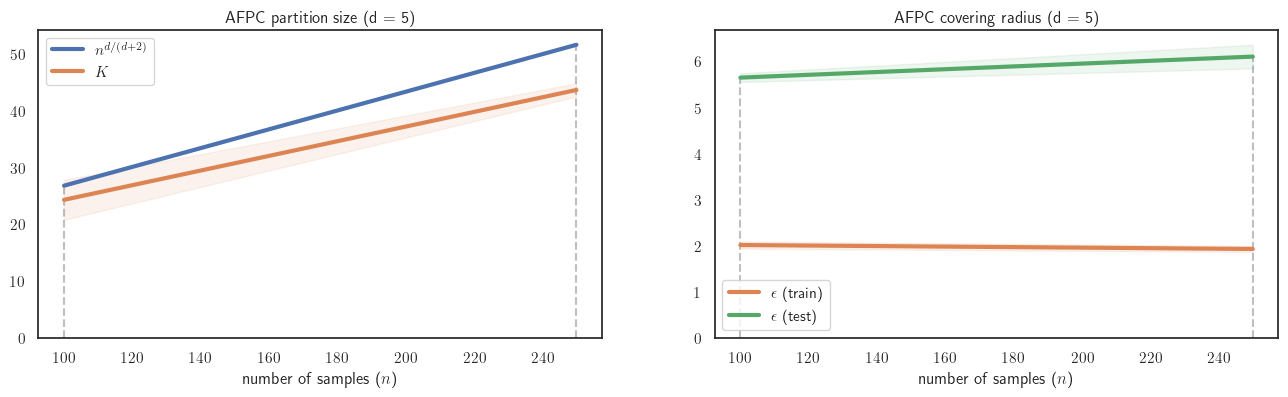

In [26]:
from notebooks.afpc_stats import (
    get_afpc_stats, plot_partition_size, plot_partition_epsilon,
)

afpc_stats = get_afpc_stats(
    domain_dims=domain_dims, nsamples=nsamples, nruns=nruns,
    data_random_seed=data_random_seed, get_data_func=get_data,
    report_loss=stat_losses[report_loss_name],
)
print('\nData statistics:')
with pd.option_context('display.max_rows', None):
    display(afpc_stats)
if output_dir is not None:
    afpc_stats.to_csv(os.path.join(output_dir, 'data_stats.csv'))

for d in domain_dims:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    plot_partition_size(ax1, d, nsamples, afpc_stats)
    plot_partition_epsilon(ax2, d, nsamples, afpc_stats)
None

## Training

In [27]:
from common.experiment import (
    calc_experiment_result,
    prepare_experiment_calc_funcs,
)

def run_experiment(d, n, estimator_name, run, data_random_seed, training_random_seed):
    result = calc_experiment_result(
        d=d, n=n, estimator_name=estimator_name, run=run,
        get_data_func=get_data, get_estimator_func=get_estimator,
        stat_losses=stat_losses, report_loss_name=report_loss_name, log_func=info,
        data_random_seed=data_random_seed, training_random_seed=training_random_seed,
        L=L, L_scaler=L_scaler,
    )
    return ((d, n, estimator_name, run), result)

delayed_funcs = prepare_experiment_calc_funcs(
    domain_dims=domain_dims, nsamples=nsamples, nruns=nruns, estimators=estimators,
    data_random_seed=data_random_seed, training_random_seed=training_random_seed,
    result_cache=result_cache, run_experiment_func=run_experiment,
)
try:
    results = OrderedDict(sorted(Parallel(n_jobs=parallel_nworkers, backend=parallel_backend)(delayed_funcs)))
except Exception:
    eprint(traceback.format_exc())
    time.sleep(3)
    raise
info('All results have been calculated.')

experiment_runner (802c74e54176e9ae811cbfa26562e383): [('d', 3), ('n', 100), ('estimator_name', 'OLS'), ('run', 0), ('data_random_seed', 245540), ('training_random_seed', 197863)]
seed: 245840, d:3, n:100, run:0, data_random_seed:245540
2025-01-27 13:39:33|INFO|PID:16987|
Experiment, d: 3, n: 100, estimator: OLS, L_true: 8.4, run: 0,
train data, minX: -3.27, maxX: 3.38, minXnorm: 0.4720, maxXnorm: 3.73,
            miny: -0.14, meany: 3.3239, stdy: 1.5217, maxy: 6.61,
 test data, minX: -5.51, maxX: 5.22, minXnorm: 0.0091, maxXnorm: 5.61,
            miny: 0.01, meany: 3.4779, stdy: 1.4667, maxy: 20.88,


2025-01-27 13:39:33|INFO|PID:16987|
Result, d: 3, n: 100, estimator: OLS, run: 0, loss: l2
 train, err: 0.8956, risk: 0.9777, real_time: 1s,
  test, err: 0.8195, real_time: 1s

experiment_runner (3a2c639ddc24367d59db50cb60f0f190): [('d', 3), ('n', 100), ('estimator_name', 'OLS'), ('run', 1), ('data_random_seed', 245540), ('training_random_seed', 197863)]
seed: 245841, d:3, n:100, run:1

## Evaluation

In [32]:
skipped_estimators = ('OLS',)

In [33]:
from common.experiment import collect_estimator_stats

all_stats = OrderedDict()
for estimator_name in list(estimators.keys()):
    stats = collect_estimator_stats(estimator_name, results)
    print('\nestimator: {}'.format(estimator_name))
    all_stats[estimator_name] = stats
    with pd.option_context('display.max_rows', None):
        display(stats)

if output_dir is not None:
    for k, v in all_stats.items():
        v.to_csv(os.path.join(output_dir, f'stats-{k}.csv'))


estimator: OLS


d                                        3                           5  \
n                                      100           250           100   
train_l1-risk__mean           5.350852e-01  5.848217e-01  7.737269e-01   
train_l1-risk__std            9.950156e-02  2.939734e-02  8.592190e-02   
train_l1-risk__min            4.107227e-01  5.602404e-01  6.683988e-01   
train_l1-risk__median         5.402460e-01  5.680759e-01  7.739184e-01   
train_l1-risk__max            6.542868e-01  6.261490e-01  8.788634e-01   
train_diff_median__mean       1.001186e-01  1.110471e-01  1.435295e-01   
train_diff_median__std        4.873938e-02  1.904011e-02  2.989946e-02   
train_diff_median__min        6.322362e-02  8.676429e-02  1.189804e-01   
train_diff_median__median     6.814424e-02  1.131115e-01  1.259884e-01   
train_diff_median__max        1.689879e-01  1.332656e-01  1.856197e-01   
test_cpu_time__mean           3.115744e-02  3.121816e-02  4.712676e-02   
test_cpu_time__std            6.115548e-05  1.560484e-04  1.367092e-03   
test_cpu_time__min            3.110556e-02  3.100595e-02  4.582927e-02   
test_cpu_time__median         3.112346e-02  3.127184e-02  4.653422e-02   
test_cpu_time__max            3.124331e-02  3.137671e-02  4.901679e-02   
test_linf-error__mean         1.837646e+01  1.896143e+01  2.115743e+01   
test_linf-error__std          9.375231e-01  1.645299e+00  1.397636e+00   
test_linf-error__min          1.715909e+01  1.740872e+01  1.997332e+01   
test_linf-error__median       1.853024e+01  1.823701e+01  2.037890e+01   
test_linf-error__max          1.944005e+01  2.123856e+01  2.312006e+01   
test_real_time__mean          3.116012e-02  3.122083e-02  4.712947e-02   
test_real_time__std           6.114062e-05  1.561968e-04  1.366959e-03   
test_real_time__min           3.110814e-02  3.100848e-02  4.583216e-02   
test_real_time__median        3.112626e-02  3.127432e-02  4.653692e-02   
test_real_time__max           3.124595e-02  3.137970e-02  4.901934e-02   
train_linf-error__mean        4.480042e+00  4.919757e+00  4.725710e+00   
train_linf-error__std         1.699966e+00  1.440462e+00  2.244425e+00   
train_linf-error__min         2.078154e+00  3.599714e+00  2.873293e+00   
train_linf-error__median      5.591382e+00  4.236085e+00  3.419749e+00   
train_linf-error__max         5.770589e+00  6.923472e+00  7.884088e+00   
train_l1-error__mean          4.783571e-01  5.400891e-01  7.552278e-01   
train_l1-error__std           1.153555e-01  2.413409e-02  8.360045e-02   
train_l1-error__min           3.341781e-01  5.098922e-01  6.664848e-01   
train_l1-error__median        4.843430e-01  5.414111e-01  7.319453e-01   
train_l1-error__max           6.165500e-01  5.689641e-01  8.672533e-01   
train_linf-risk__mean         4.300752e+00  4.751326e+00  4.500638e+00   
train_linf-risk__std          1.981869e+00  1.340869e+00  2.221410e+00   
train_linf-risk__min          1.498465e+00  3.550053e+00  2.810300e+00   
train_linf-risk__median       5.656110e+00  4.081292e+00  3.052545e+00   
train_linf-risk__max          5.747681e+00  6.622633e+00  7.639071e+00   
test_l2-error__mean           8.455184e-01  8.023382e-01  1.538036e+00   
test_l2-error__std            2.273371e-02  3.982591e-03  1.532176e-01   
test_l2-error__min            8.194619e-01  7.969760e-01  1.407304e+00   
test_l2-error__median         8.422364e-01  8.035272e-01  1.453752e+00   
test_l2-error__max            8.748570e-01  8.065114e-01  1.753052e+00   
train_l2-error__mean          5.740734e-01  6.327605e-01  1.102058e+00   
train_l2-error__std           2.728779e-01  7.974299e-02  3.720209e-01   
train_l2-error__min           2.284695e-01  5.329241e-01  7.798833e-01   
train_l2-error__median        5.981744e-01  6.372594e-01  9.029336e-01   
train_l2-error__max           8.955764e-01  7.280982e-01  1.623356e+00   
train_l2-risk__mean           6.459529e-01  7.091407e-01  1.137759e+00   
train_l2-risk__std            2.808208e-01  7.140157e-02  3.550085e-01   
trai


estimator: CAP


d                                        3                             5  \
n                                      100            250            100   
train_l1-risk__mean           2.291069e-01       0.254155       0.342313   
train_l1-risk__std            2.394328e-03       0.011341       0.047141   
train_l1-risk__min            2.260041e-01       0.242337       0.291572   
train_l1-risk__median         2.294841e-01       0.250672       0.330234   
train_l1-risk__max            2.318325e-01       0.269454       0.405133   
train_diff_median__mean       1.466285e-02      -0.002720       0.043604   
train_diff_median__std        2.214007e-03       0.029944       0.022497   
train_diff_median__min        1.164582e-02      -0.042590       0.026729   
train_diff_median__median     1.544616e-02       0.004855       0.028684   
train_diff_median__max        1.689656e-02       0.029575       0.075400   
test_cpu_time__mean           9.169638e-02       0.095470       0.114599   
test_cpu_time__std            3.147704e-04       0.003531       0.006839   
test_cpu_time__min            9.125367e-02       0.092807       0.105590   
test_cpu_time__median         9.187743e-02       0.093143       0.116055   
test_cpu_time__max            9.195806e-02       0.100460       0.122151   
test_linf-error__mean         1.111243e+01      11.035535      18.664936   
test_linf-error__std          9.633518e-01       0.532817       2.132302   
test_linf-error__min          9.921280e+00      10.579765      15.700034   
test_linf-error__median       1.113534e+01      10.743759      19.670852   
test_linf-error__max          1.228067e+01      11.783080      20.623923   
test_real_time__mean          9.169912e-02       0.095472       0.114601   
test_real_time__std           3.146230e-04       0.003531       0.006839   
test_real_time__min           9.125662e-02       0.092809       0.105593   
test_real_time__median        9.188008e-02       0.093146       0.116057   
test_real_time__max           9.196067e-02       0.100462       0.122154   
train_linf-error__mean        5.409538e-01       0.733292       1.600235   
train_linf-error__std         6.420635e-02       0.154716       0.416058   
train_linf-error__min         4.532958e-01       0.592091       1.135090   
train_linf-error__median      5.642707e-01       0.659143       1.520738   
train_linf-error__max         6.052948e-01       0.948641       2.144876   
train_l1-error__mean          9.713882e-02       0.102997       0.289643   
train_l1-error__std           8.277632e-03       0.015113       0.028097   
train_l1-error__min           8.785974e-02       0.089571       0.256610   
train_l1-error__median        9.559753e-02       0.095308       0.287033   
train_l1-error__max           1.079592e-01       0.124112       0.325286   
train_linf-risk__mean         8.741789e-01       0.983856       1.446035   
train_linf-risk__std          9.974922e-02       0.042024       0.260318   
train_linf-risk__min          7.961687e-01       0.950962       1.091455   
train_linf-risk__median       8.113965e-01       0.957436       1.537575   
train_linf-risk__max          1.014971e+00       1.043168       1.709075   
test_l2-error__mean           1.235030e-01       0.088956       0.814247   
test_l2-error__std            3.913773e-02       0.017601       0.196584   
test_l2-error__min            6.838212e-02       0.073748       0.616978   
test_l2-error__median         1.467152e-01       0.079494       0.743229   
test_l2-error__max            1.554118e-01       0.113625       1.082533   
train_l2-error__mean          2.055205e-02       0.027921       0.190265   
train_l2-error__std           3.496227e-03       0.009517       0.063474   
train_l2-error__min           1.709815e-02       0.019594       0.121131   
train_l2-error__median        1.921496e-02       0.022928       0.175247   
train_l2-error__max           2.534304e-02       0.041242       0.274418   
train_l2-risk__mean           8.648664e-02      


estimator: AMAP


d                                         3                             5  \
n                                       100            250            100   
train_l1-risk__mean                0.258536       0.240679       0.311976   
train_l1-risk__std                 0.020555       0.001651       0.029893   
train_l1-risk__min                 0.235002       0.238348       0.276730   
train_l1-risk__median              0.255526       0.241727       0.309384   
train_l1-risk__max                 0.285080       0.241963       0.349814   
train_diff_median__mean            0.038097      -0.008677       0.028139   
train_diff_median__std             0.034343       0.000413       0.024725   
train_diff_median__min            -0.000060      -0.009195       0.003620   
train_diff_median__median          0.031153      -0.008652       0.018809   
train_diff_median__max             0.083199      -0.008185       0.061988   
test_cpu_time__mean                0.093981       0.104342       0.126344   
test_cpu_time__std                 0.001452       0.008765       0.006656   
test_cpu_time__min                 0.092081       0.093768       0.121120   
test_cpu_time__median              0.094254       0.104028       0.122175   
test_cpu_time__max                 0.095606       0.115229       0.135737   
test_linf-error__mean             14.475690      10.189533      17.951954   
test_linf-error__std               0.709839       1.263073       2.233443   
test_linf-error__min              13.841446       8.476566      14.862221   
test_linf-error__median           14.118937      10.607452      18.928874   
test_linf-error__max              15.466686      11.484580      20.064767   
test_real_time__mean               0.093983       0.104344       0.126347   
test_real_time__std                0.001452       0.008765       0.006656   
test_real_time__min                0.092084       0.093770       0.121122   
test_real_time__median             0.094257       0.104031       0.122178   
test_real_time__max                0.095609       0.115232       0.135740   
train_linf-error__mean             0.695440       0.862724       1.439192   
train_linf-error__std              0.099677       0.110001       0.255695   
train_linf-error__min              0.606466       0.741480       1.098495   
train_linf-error__median           0.645237       0.838934       1.504595   
train_linf-error__max              0.834617       1.007757       1.714487   
train_l1-error__mean               0.135074       0.106024       0.271924   
train_l1-error__std                0.015143       0.011688       0.032357   
train_l1-error__min                0.117316       0.089527       0.241910   
train_l1-error__median             0.133589       0.113363       0.257017   
train_l1-error__max                0.154319       0.115181       0.316844   
train_linf-risk__mean              0.951499       0.988963       1.416314   
train_linf-risk__std               0.023799       0.117182       0.404606   
train_linf-risk__min               0.928536       0.825114       1.070527   
train_linf-risk__median            0.941671       1.049380       1.194387   
train_linf-risk__max               0.984291       1.092395       1.984027   
test_l2-error__mean                0.237526       0.092292       0.849983   
test_l2-error__std                 0.062286       0.011177       0.150480   
test_l2-error__min                 0.161161       0.076983       0.720625   
test_l2-error__median              0.237688       0.096539       0.768319   
test_l2-error__max                 0.313729       0.103353       1.061005   
train_l2-error__mean               0.040839       0.026430       0.161533   
train_l2-error__std                0.006599       0.000262       0.047045   
train_l2-error__min                0.032861       0.026086       0.111333   
train_l2-error__median             0.040633       0.026483       0.148820   
train_l2-error__max                0.049021       0.026721       0.224446


estimator: APCNLS_star


d                                        3                           5  \
n                                      100           250           100   
train_l1-risk__mean           2.375154e-01  2.777445e-01  1.690404e-01   
train_l1-risk__std            1.861323e-02  1.681105e-02  2.213031e-02   
train_l1-risk__min            2.112839e-01  2.563267e-01  1.377737e-01   
train_l1-risk__median         2.487307e-01  2.795161e-01  1.834820e-01   
train_l1-risk__max            2.525315e-01  2.973907e-01  1.858656e-01   
train_diff_median__mean       2.948369e-03  1.291152e-03  1.563406e-03   
train_diff_median__std        7.161708e-03  1.782199e-03  2.210954e-03   
train_diff_median__min       -3.968839e-03 -2.490807e-08  1.547219e-08   
train_diff_median__median     3.775747e-09  6.217541e-05  3.525094e-08   
train_diff_median__max        1.281394e-02  3.811306e-03  4.690167e-03   
test_cpu_time__mean           1.856098e-01  2.531673e-01  3.193146e-01   
test_cpu_time__std            1.294867e-03  1.583283e-02  6.666181e-02   
test_cpu_time__min            1.838867e-01  2.307763e-01  2.344332e-01   
test_cpu_time__median         1.859344e-01  2.643515e-01  3.262300e-01   
test_cpu_time__max            1.870082e-01  2.643742e-01  3.972807e-01   
test_linf-error__mean         1.449057e+01  1.021806e+01  1.405419e+01   
test_linf-error__std          1.337524e+00  1.226238e+00  1.157535e+00   
test_linf-error__min          1.320850e+01  8.844895e+00  1.266660e+01   
test_linf-error__median       1.392716e+01  9.987410e+00  1.399580e+01   
test_linf-error__max          1.633605e+01  1.182187e+01  1.550016e+01   
test_real_time__mean          1.856126e-01  2.531701e-01  3.193173e-01   
test_real_time__std           1.295116e-03  1.583311e-02  6.666191e-02   
test_real_time__min           1.838892e-01  2.307787e-01  2.344358e-01   
test_real_time__median        1.859374e-01  2.643545e-01  3.262327e-01   
test_real_time__max           1.870112e-01  2.643771e-01  3.972836e-01   
train_linf-error__mean        7.005837e-01  9.410950e-01  8.311716e-01   
train_linf-error__std         1.686230e-01  1.343982e-01  3.836999e-02   
train_linf-error__min         5.807825e-01  7.535447e-01  7.801525e-01   
train_linf-error__median      5.819168e-01  1.008169e+00  8.406758e-01   
train_linf-error__max         9.390518e-01  1.061572e+00  8.726865e-01   
train_l1-error__mean          1.482680e-01  1.834465e-01  1.888786e-01   
train_l1-error__std           9.948882e-03  1.524356e-02  2.736382e-02   
train_l1-error__min           1.365983e-01  1.640956e-01  1.527944e-01   
train_l1-error__median        1.472958e-01  1.848933e-01  1.948120e-01   
train_l1-error__max           1.609098e-01  2.013504e-01  2.190293e-01   
train_linf-risk__mean         8.700578e-01  1.090252e+00  7.677378e-01   
train_linf-risk__std          8.520158e-02  1.297144e-01  8.414576e-02   
train_linf-risk__min          7.551724e-01  9.356787e-01  6.751990e-01   
train_linf-risk__median       8.960367e-01  1.081987e+00  7.492139e-01   
train_linf-risk__max          9.589643e-01  1.253090e+00  8.788007e-01   
test_l2-error__mean           3.666410e-01  1.229791e-01  7.849546e-01   
test_l2-error__std            1.518542e-01  3.171073e-02  2.585231e-01   
test_l2-error__min            2.552453e-01  9.828852e-02  4.760298e-01   
test_l2-error__median         2.633331e-01  1.029031e-01  7.700790e-01   
test_l2-error__max            5.813445e-01  1.677456e-01  1.108755e+00   
train_l2-error__mean          4.290958e-02  6.063154e-02  6.067290e-02   
train_l2-error__std           2.604027e-03  1.054546e-02  1.229931e-02   
train_l2-error__min           3.945676e-02  4.684547e-02  4.458809e-02   
train_l2-error__median        4.352696e-02  6.259830e-02  6.298218e-02   
train_l2-error__max           4.574503e-02  7.245086e-02  7.444843e-02   
train_l2-risk__mean           1.007274e-01  1.262235e-01  6.240096e-02   
train_l2-risk__std            1.495512e-02  1.936216e-02  1.690067e-02   
trai


estimator: APCNLS_ln


d                                        3                           5  \
n                                      100           250           100   
train_l1-risk__mean           2.375250e-01  2.777445e-01  1.691386e-01   
train_l1-risk__std            1.859947e-02  1.681107e-02  2.199143e-02   
train_l1-risk__min            2.113131e-01  2.563267e-01  1.380685e-01   
train_l1-risk__median         2.487307e-01  2.795161e-01  1.834819e-01   
train_l1-risk__max            2.525313e-01  2.973907e-01  1.858655e-01   
train_diff_median__mean       2.948473e-03  1.291158e-03  1.563155e-03   
train_diff_median__std        7.161576e-03  1.782191e-03  2.210604e-03   
train_diff_median__min       -3.968486e-03 -3.530003e-09  4.378990e-09   
train_diff_median__median     2.503863e-09  6.217642e-05  3.807813e-08   
train_diff_median__max        1.281390e-02  3.811300e-03  4.689421e-03   
test_cpu_time__mean           1.893299e-01  2.538962e-01  2.862991e-01   
test_cpu_time__std            3.115585e-03  1.571173e-02  2.299785e-02   
test_cpu_time__min            1.861573e-01  2.316780e-01  2.558046e-01   
test_cpu_time__median         1.882683e-01  2.647760e-01  2.917528e-01   
test_cpu_time__max            1.935641e-01  2.652345e-01  3.113400e-01   
test_linf-error__mean         1.259850e+01  1.022289e+01  1.391379e+01   
test_linf-error__std          1.401889e+00  1.225349e+00  9.875158e-01   
test_linf-error__min          1.065983e+01  8.844895e+00  1.266653e+01   
test_linf-error__median       1.320850e+01  1.000190e+01  1.399331e+01   
test_linf-error__max          1.392716e+01  1.182187e+01  1.508152e+01   
test_real_time__mean          1.893325e-01  2.538987e-01  2.863019e-01   
test_real_time__std           3.115481e-03  1.571150e-02  2.299764e-02   
test_real_time__min           1.861601e-01  2.316809e-01  2.558076e-01   
test_real_time__median        1.882708e-01  2.647781e-01  2.917557e-01   
test_real_time__max           1.935666e-01  2.652371e-01  3.113425e-01   
train_linf-error__mean        7.000353e-01  9.410951e-01  8.265222e-01   
train_linf-error__std         1.690103e-01  1.343981e-01  3.777689e-02   
train_linf-error__min         5.802715e-01  7.535450e-01  7.801529e-01   
train_linf-error__median      5.807826e-01  1.008169e+00  8.267273e-01   
train_linf-error__max         9.390518e-01  1.061572e+00  8.726863e-01   
train_l1-error__mean          1.482155e-01  1.834464e-01  1.888344e-01   
train_l1-error__std           9.954365e-03  1.524361e-02  2.735436e-02   
train_l1-error__min           1.365982e-01  1.640955e-01  1.527945e-01   
train_l1-error__median        1.471385e-01  1.848933e-01  1.946791e-01   
train_l1-error__max           1.609098e-01  2.013504e-01  2.190295e-01   
train_linf-risk__mean         8.701041e-01  1.090252e+00  7.676954e-01   
train_linf-risk__std          8.521568e-02  1.297143e-01  8.419242e-02   
train_linf-risk__min          7.551725e-01  9.356788e-01  6.750720e-01   
train_linf-risk__median       8.961756e-01  1.081987e+00  7.492135e-01   
train_linf-risk__max          9.589643e-01  1.253090e+00  8.788008e-01   
test_l2-error__mean           2.802070e-01  1.223172e-01  7.127107e-01   
test_l2-error__std            4.059518e-02  3.163293e-02  1.799069e-01   
test_l2-error__min            2.457784e-01  9.718166e-02  4.690305e-01   
test_l2-error__median         2.576349e-01  1.028363e-01  7.711894e-01   
test_l2-error__max            3.372077e-01  1.669336e-01  8.979122e-01   
train_l2-error__mean          4.283888e-02  6.063154e-02  6.059683e-02   
train_l2-error__std           2.697857e-03  1.054546e-02  1.228548e-02   
train_l2-error__min           3.924483e-02  4.684546e-02  4.458814e-02   
train_l2-error__median        4.352697e-02  6.259830e-02  6.275390e-02   
train_l2-error__max           4.574485e-02  7.245086e-02  7.444846e-02   
train_l2-risk__mean           1.006944e-01  1.262234e-01  6.240258e-02   
train_l2-risk__std            1.499598e-02  1.936220e-02  1.689853e-02   
trai


estimator: XGB


d                                        3                            5  \
n                                      100            250           100   
train_l1-risk__mean           8.921182e-04       0.003739  6.483679e-04   
train_l1-risk__std            5.923871e-05       0.000974  8.547451e-05   
train_l1-risk__min            8.099693e-04       0.002883  5.289333e-04   
train_l1-risk__median         9.189618e-04       0.003232  6.919492e-04   
train_l1-risk__max            9.474234e-04       0.005101  7.242211e-04   
train_diff_median__mean      -1.759579e-05      -0.000008 -6.989239e-05   
train_diff_median__std        6.204612e-05       0.000098  1.536806e-05   
train_diff_median__min       -9.886627e-05      -0.000108 -8.960149e-05   
train_diff_median__median    -5.612156e-06      -0.000040 -6.797065e-05   
train_diff_median__max        5.169105e-05       0.000125 -5.210504e-05   
test_cpu_time__mean           6.219140e-01       0.846724  7.889022e-01   
test_cpu_time__std            8.076786e-03       0.025983  1.421161e-01   
test_cpu_time__min            6.108542e-01       0.817472  6.724446e-01   
test_cpu_time__median         6.249715e-01       0.842090  7.052730e-01   
test_cpu_time__max            6.299163e-01       0.880610  9.889890e-01   
test_linf-error__mean         1.569911e+01      15.050599  1.691155e+01   
test_linf-error__std          6.389311e-01       0.498498  7.693212e-01   
test_linf-error__min          1.487117e+01      14.405989  1.611056e+01   
test_linf-error__median       1.579964e+01      15.125702  1.667440e+01   
test_linf-error__max          1.642651e+01      15.620106  1.794969e+01   
test_real_time__mean          6.219172e-01       0.846726  7.889047e-01   
test_real_time__std           8.076650e-03       0.025983  1.421160e-01   
test_real_time__min           6.108575e-01       0.817475  6.724472e-01   
test_real_time__median        6.249750e-01       0.842092  7.052755e-01   
test_real_time__max           6.299191e-01       0.880612  9.889915e-01   
train_linf-error__mean        8.752002e-01       0.977602  8.452236e-01   
train_linf-error__std         1.261040e-01       0.127730  7.831498e-02   
train_linf-error__min         7.478278e-01       0.852055  7.737785e-01   
train_linf-error__median      8.307867e-01       0.927899  8.076553e-01   
train_linf-error__max         1.046986e+00       1.152853  9.542370e-01   
train_l1-error__mean          2.427809e-01       0.239960  2.330848e-01   
train_l1-error__std           1.554831e-02       0.007837  1.226955e-02   
train_l1-error__min           2.213909e-01       0.229466  2.158699e-01   
train_l1-error__median        2.490627e-01       0.242117  2.398087e-01   
train_l1-error__max           2.578890e-01       0.248296  2.435758e-01   
train_linf-risk__mean         3.450035e-03       0.019469  3.334029e-03   
train_linf-risk__std          1.282255e-04       0.005241  4.687714e-04   
train_linf-risk__min          3.297011e-03       0.014452  2.957636e-03   
train_linf-risk__median       3.442284e-03       0.017252  3.049609e-03   
train_linf-risk__max          3.610811e-03       0.026702  3.994841e-03   
test_l2-error__mean           5.695618e-01       0.328805  1.476100e+00   
test_l2-error__std            4.054892e-02       0.015330  5.527629e-02   
test_l2-error__min            5.227064e-01       0.308197  1.402769e+00   
test_l2-error__median         5.643582e-01       0.333279  1.489309e+00   
test_l2-error__max            6.216208e-01       0.344939  1.536221e+00   
train_l2-error__mean          9.980040e-02       0.089247  8.732050e-02   
train_l2-error__std           1.611122e-02       0.004678  1.051423e-02   
train_l2-error__min           7.734852e-02       0.084011  7.451595e-02   
train_l2-error__median        1.076660e-01       0.088364  8.717631e-02   
train_l2-error__max           1.143867e-01       0.095367  1.002692e-01   
train_l2-risk__mean           1.421522e-06       0.000030  8.316739e-07   
train_l2-risk__std       


estimator: RF


d                                         3                             5  \
n                                       100            250            100   
train_l1-risk__mean                0.177182       0.161277       0.305896   
train_l1-risk__std                 0.004813       0.000776       0.013843   
train_l1-risk__min                 0.170517       0.160349       0.290160   
train_l1-risk__median              0.179313       0.161235       0.303678   
train_l1-risk__max                 0.181714       0.162248       0.323851   
train_diff_median__mean           -0.008533      -0.004228       0.002720   
train_diff_median__std             0.008766       0.011673       0.003752   
train_diff_median__min            -0.015538      -0.018944      -0.002351   
train_diff_median__median         -0.013889      -0.003349       0.003904   
train_diff_median__max             0.003828       0.009608       0.006608   
test_cpu_time__mean                4.492253       6.977344       4.573309   
test_cpu_time__std                 0.018933       0.147219       0.041765   
test_cpu_time__min                 4.469221       6.775221       4.518608   
test_cpu_time__median              4.491944       7.035165       4.581362   
test_cpu_time__max                 4.515594       7.121646       4.619956   
test_linf-error__mean             15.558503      16.068040      17.078933   
test_linf-error__std               1.117471       1.092557       0.871634   
test_linf-error__min              14.506546      15.217797      16.116643   
test_linf-error__median           15.063135      15.375872      16.892906   
test_linf-error__max              17.105830      17.610451      18.227249   
test_real_time__mean               4.492256       6.977347       4.573311   
test_real_time__std                0.018933       0.147219       0.041765   
test_real_time__min                4.469223       6.775223       4.518610   
test_real_time__median             4.491946       7.035168       4.581365   
test_real_time__max                4.515597       7.121649       4.619958   
train_linf-error__mean             1.353691       1.601878       1.741353   
train_linf-error__std              0.307779       0.336139       0.786363   
train_linf-error__min              0.929508       1.306371       0.997282   
train_linf-error__median           1.481263       1.427156       1.397623   
train_linf-error__max              1.650301       2.072108       2.829153   
train_l1-error__mean               0.247027       0.216713       0.342564   
train_l1-error__std                0.016659       0.003854       0.030425   
train_l1-error__min                0.231738       0.211935       0.299539   
train_l1-error__median             0.239149       0.216833       0.363689   
train_l1-error__max                0.270194       0.221372       0.364465   
train_linf-risk__mean              1.253480       1.318269       1.565844   
train_linf-risk__std               0.473061       0.324020       0.723855   
train_linf-risk__min               0.587055       1.031962       0.965811   
train_linf-risk__median            1.535822       1.151578       1.147585   
train_linf-risk__max               1.637562       1.771268       2.584136   
test_l2-error__mean                0.522328       0.353015       1.323555   
test_l2-error__std                 0.029025       0.002167       0.069574   
test_l2-error__min                 0.497488       0.351201       1.250647   
test_l2-error__median              0.506448       0.351783       1.302789   
test_l2-error__max                 0.563049       0.356060       1.417228   
train_l2-error__mean               0.103532       0.085160       0.218014   
train_l2-error__std                0.014939       0.006347       0.054335   
train_l2-error__min                0.092714       0.078654       0.151537   
train_l2-error__median             0.093225       0.083059       0.217874   
train_l2-error__max                0.124656       0.093768       0.284630

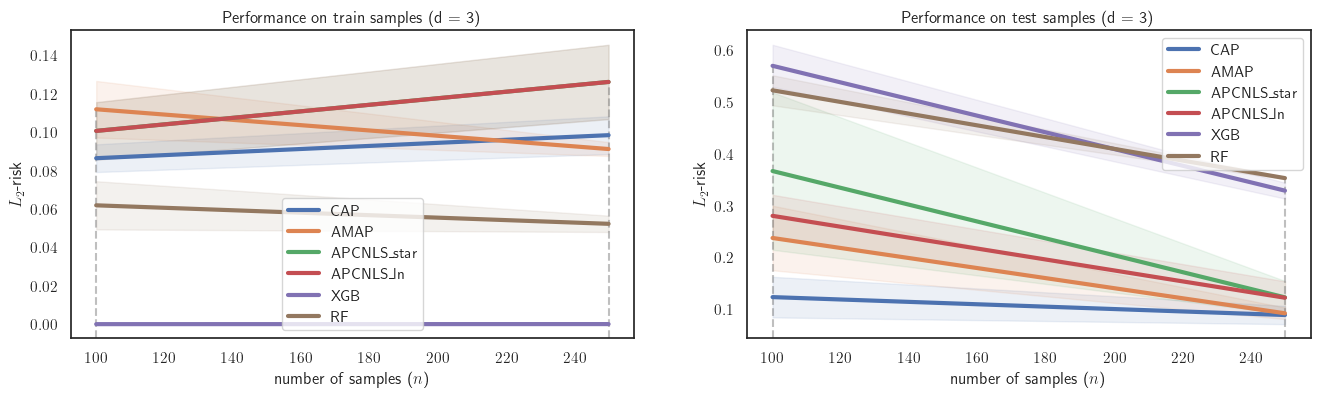

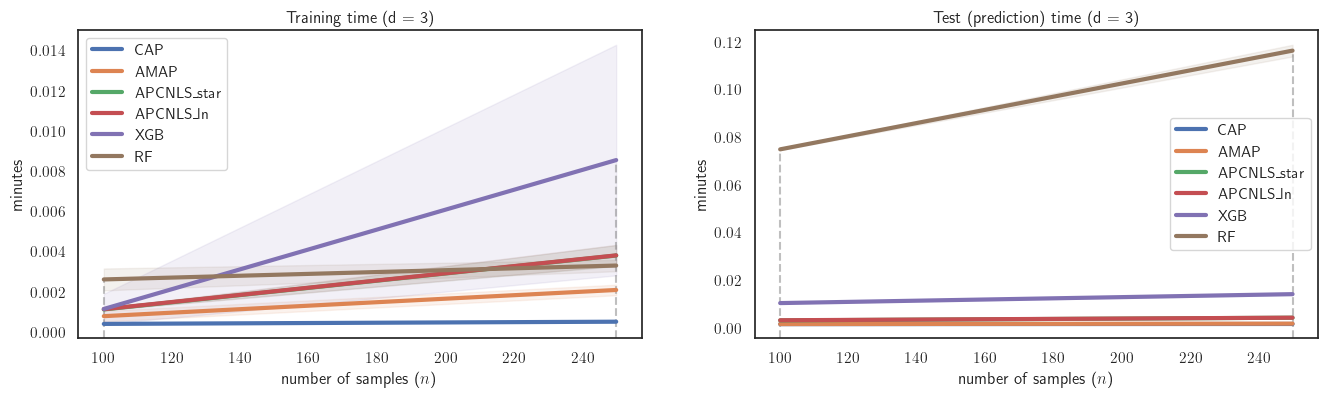

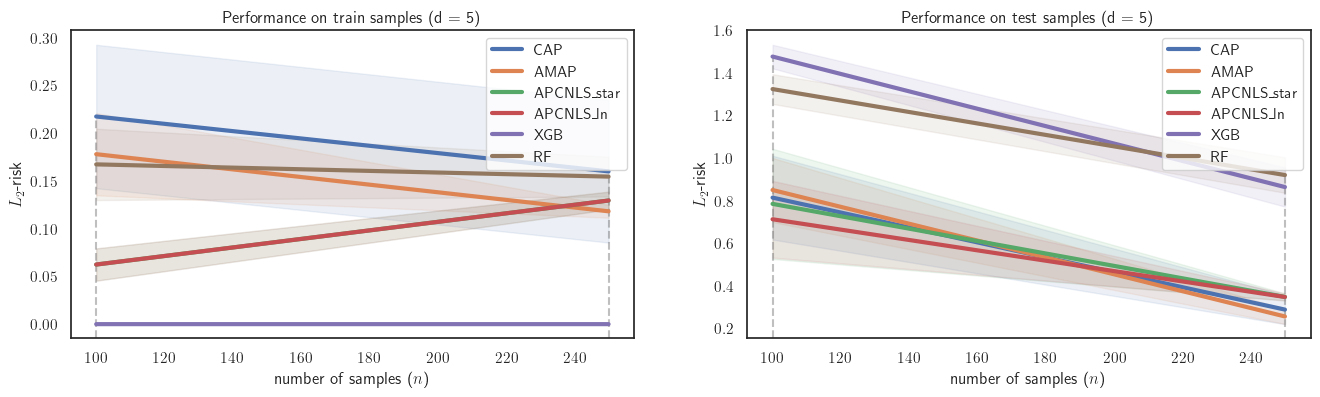

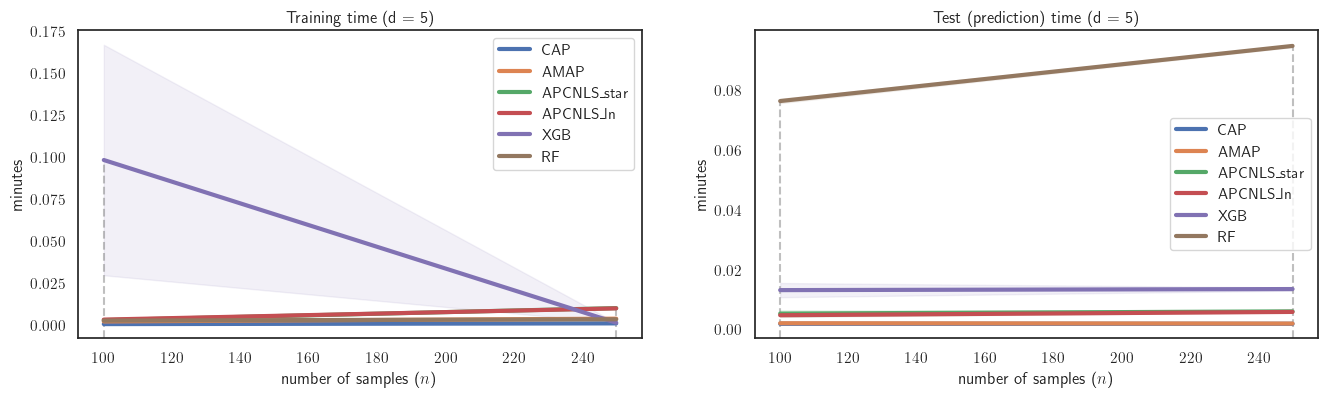

In [34]:
from notebooks.evaluation import plot_standard_stats

for d in domain_dims:
    plot_standard_stats(
        all_stats=all_stats, report_loss_name=report_loss_name,
        d=d, skipped_estimators=skipped_estimators,
    )

### FVU (Fraction of Variance Unexplained) 

In [37]:
from common.experiment import collect_stats_by_name

fvu = pd.concat([
    collect_stats_by_name(all_stats, 'test_fvu__mean'),
    collect_stats_by_name(all_stats, 'test_fvu__std'),
], axis=1, keys=['mean', 'std']).swaplevel(0, 1, axis=1).sort_index(axis=1)

print('FVU(%):')
display(np.round(fvu * 100, decimals=1).T)

FVU(%):


d                    3           5      
n                  100   250   100   250
AMAP        mean  11.0   4.3  23.7   7.2
            std    2.9   0.5   4.2   1.0
APCNLS_ln   mean  13.0   5.7  19.9   9.7
            std    1.9   1.5   5.0   0.5
APCNLS_star mean  17.0   5.7  21.9   9.7
            std    7.1   1.5   7.2   0.5
CAP         mean   5.7   4.1  22.7   8.1
            std    1.8   0.8   5.5   1.9
OLS         mean  39.3  37.3  42.9  38.3
            std    1.1   0.2   4.3   0.7
RF          mean  24.3  16.4  36.9  25.7
            std    1.4   0.1   2.0   2.3
XGB         mean  26.5  15.3  41.2  24.1
            std    1.9   0.7   1.6   2.6